In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import matplotlib.patches as mpatches


import cv2

In [24]:
import os
import pathlib
import sklearn
import pandas as pd
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.autonotebook import tqdm
from timeit import default_timer as timer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torchvision
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms
from torchview import draw_graph
from torch.utils.mobile_optimizer import optimize_for_mobile

In [25]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# model.to(device)


# Data

## Download Dataset Local

In [26]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("roshan81/ageutk")

# print("Path to dataset files:", path)

# /Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6

## Load in Data

In [27]:
# Put your own path here + the csv file
ageutk_path = "/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6"

ageutk_path_csv = ageutk_path + "/ageutk_full.csv"
ageutk_data = pd.read_csv(ageutk_path_csv)
ageutk_data.head()

,files,age,gender
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0
1,22_1_1_20170112233644761.jpg.chip.jpg,22,1
2,21_1_3_20170105003215901.jpg.chip.jpg,21,1
3,28_0_0_20170117180555824.jpg.chip.jpg,28,0
4,17_1_4_20170103222931966.jpg.chip.jpg,17,1


In [28]:
def add_path_to_files(df, path):
    df['path'] = df['files'].apply(lambda x: os.path.join(path+"/UTKFace/UTKFace/UTKFace/", x))
    df = df[['path', 'age', 'gender']]
    return df

ageutk_data = add_path_to_files(df=ageutk_data, path=ageutk_path)
ageutk_data.head()

,path,age,gender
0,/Users/hidde/.cache/kagglehub/datasets/roshan8...,26,0
1,/Users/hidde/.cache/kagglehub/datasets/roshan8...,22,1
2,/Users/hidde/.cache/kagglehub/datasets/roshan8...,21,1
3,/Users/hidde/.cache/kagglehub/datasets/roshan8...,28,0
4,/Users/hidde/.cache/kagglehub/datasets/roshan8...,17,1


### Preview Data

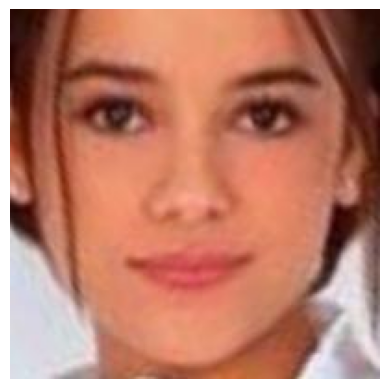

In [29]:
i = 10
ageutk_path_example = ageutk_data['path'][i]
# ageutk_path_example = '/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6/UTKFace/UTKFace/UTKFace/' + ageutk_data["files"][i]
image = cv2.imread(ageutk_path_example)
# plt.imshow(image)

# Converteer de afbeelding van BGR naar RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Toon de afbeelding met matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Verberg de assen
plt.show()


### 

In [30]:
print(f"Min age: {ageutk_data['age'].min()}, Max age: {ageutk_data['age'].max()}")
print(ageutk_data['age'].dtype)
ageutk_data.loc[ageutk_data['age'] > 70, 'age'] = 70

Min age: 1, Max age: 80
int64


### Create Class Labels for age

In [31]:
# age_bins = [0, 12, 18, 25, 55, 70]
# age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']
age_bins = [0, 18, 25, 70]
age_labels = ['Not Old Enough', 'Not Sure', 'Old Enough']

ageutk_data['age'] = pd.cut(
    ageutk_data['age'], bins=age_bins, 
    labels=age_labels, right=True
)

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)
ageutk_data

{'Not Old Enough': 0, 'Not Sure': 1, 'Old Enough': 2}


,path,age,gender
0,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Old Enough,0
1,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Not Sure,1
2,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Not Sure,1
3,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Old Enough,0
4,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Not Old Enough,1
...,...,...,...
23163,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Old Enough,0
23164,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Old Enough,0
23165,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Not Old Enough,0
23166,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Old Enough,1


In [32]:
train_ageutk, test_ageutk = train_test_split(ageutk_data, shuffle=True, test_size=0.1)
train_ageutk, val_ageutk = train_test_split(train_ageutk, shuffle=True, test_size=0.2)
display(train_ageutk.head())
print("Shape of Dataset: ", train_ageutk.shape, test_ageutk.shape)

,path,age,gender
15211,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Not Sure,0
3519,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Not Old Enough,0
22028,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Old Enough,0
13724,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Old Enough,1
11555,/Users/hidde/.cache/kagglehub/datasets/roshan8...,Not Old Enough,1


Shape of Dataset:  (16680, 3) (2317, 3)


In [33]:
# age_gender = test_ageutk.groupby(['age','gender'], observed=True).first()
# age_gender

In [34]:
## Creating a seperate folder for unseen data

output_dir = "organised_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over the rows in the DataFrame
for index, row in test_ageutk.iterrows():
    src_path = row['path']
    dest_path = os.path.join(output_dir, os.path.basename(src_path))

    try:
        shutil.copy(src_path, dest_path)
    except Exception as e:
        print("Failed to copy {src_path}: {e}")

### Data Transformation

In [35]:
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
def plot_transformed_images(image_dataset: pd.DataFrame, transform, n=3, seed=None):
    """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
    image_paths = list(image_dataset['path'])
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f'Original Image \nSize: {f.size}')
            ax[0].axis(False)

            # Transformed Image
            transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C) for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Image \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            # Here a list comprehension because suptitle trys to find class information
            image_class = [x for x in image_dataset[image_dataset["path"]==image_path]['age']][0]
            fig.suptitle(f'Class: {image_class}', fontsize=14)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..1.7351656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.2489083].


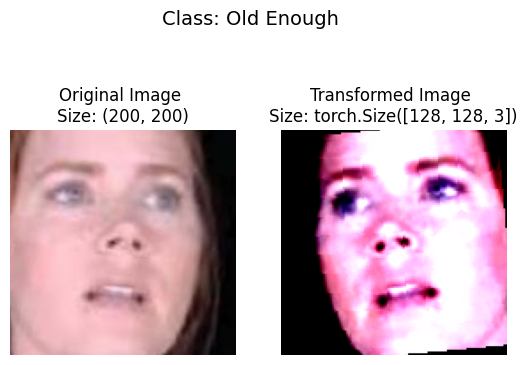

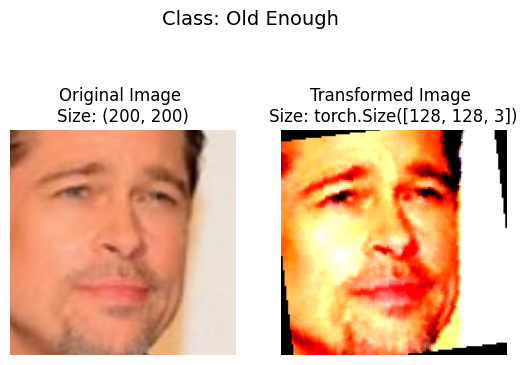

In [ ]:

plot_transformed_images(image_dataset=train_ageutk,
                        transform=train_transform,
                        n=2,
                        seed=55)



# Create Dataset

In [38]:
class Image_Dataset(Dataset):
    def __init__(self, ageutk_data:pd.DataFrame, age_idx:dict, transform=None):
        self.ageutk_df = ageutk_data
        self.transform = transform
        self.age_idx = age_idx

    def __len__(self):
        return len(self.ageutk_df)

    def __getitem__(self, idx):
        row = self.ageutk_df.iloc[idx]
        image = Image.open(row['path'])
        label = [
            self.age_idx[row['age']],
            row['gender'],
            -1
        ]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)

In [39]:
train_dataset = Image_Dataset(ageutk_data=train_ageutk,
                                    transform=train_transform, age_idx=age_idx)

val_dataset = Image_Dataset(ageutk_data=val_ageutk,
                                    transform=test_transform, age_idx=age_idx)

test_dataset = Image_Dataset(ageutk_data=test_ageutk, age_idx=age_idx, 
                                    transform=test_transform)


train_dataloader = DataLoader(train_dataset, batch_size=16, 
                                       shuffle=True, num_workers=0) #num_workers=os.cpu_count())

val_dataloader = DataLoader(val_dataset, batch_size=16,
                                     shuffle=True, num_workers=0) #num_workers=os.cpu_count())

test_dataloader = DataLoader(test_dataset, batch_size=16, 
                                      shuffle=True, num_workers=0) #num_workers=os.cpu_count())

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from torchvision import transforms

# 2 Functie om DataLoader naar NumPy om te zetten
def dataloader_to_numpy(dataloader):
    X_list, y_list = [], []
    
    for X_batch, y_batch in dataloader:
        X_list.append(X_batch.view(X_batch.size(0), -1).numpy())  # 1D vector
        y_list.append(y_batch.numpy()[:, 0])  # Alleen leeftijd gebruiken
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    return X, y

# 3️ Converteer data voor RandomForest
X_train, y_train = dataloader_to_numpy(train_dataloader)
X_val, y_val = dataloader_to_numpy(val_dataloader)
X_test, y_test = dataloader_to_numpy(test_dataloader)

# 4️ Train een RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=55)
clf.fit(X_train, y_train)

# 5️ Valideer model
y_pred_val = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# 6️⃣ Test model
y_pred_test = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Validation Accuracy: 0.75
Test Accuracy: 0.76


In [41]:
# train_images, train_labels = next(iter(train_dataloader))
# train_images.shape, train_labels.shape, train_labels[:5]

In [42]:
# val_images, val_labels = next(iter(val_dataloader))
# val_images.shape, val_labels.shape, val_labels[:5]

In [43]:
# Visualize images with their labels
def visualize_batch(images, labels):
    """
    Visualizes a batch of images in an 4x4 grid.
    
    Parameters:
        images (torch.Tensor): Batch of images (B, C, H, W).
        labels (list): Corresponding labels [[age_idx, gender_idx, emotion_idx], ...].
    """
    # Define the grid size
    rows, cols = 4, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
    
    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            ax.axis('off')
            continue
        
        image = images[i]
        
        # Display the image
        ax.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        ax.set_title(f"Age Id: {labels[i][0]}\nGender Id: {labels[i][1]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [44]:
visualize_batch(train_images, train_labels)

NameError: name 'train_images' is not defined

In [ ]:
visualize_batch(val_images, val_labels)